In [43]:
import os
import json
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle
import joblib 
import json

In [2]:
os.chdir('..')

In [3]:
test = pd.read_csv('ENG_DATA/SELECTED/05-01_cat_transformed_test.csv', index_col = [0])
train = pd.read_csv('ENG_DATA/SELECTED/05-01_cat_transformed_train.csv', index_col = [0])
df = pd.concat([test, train])

# Define Functions

In [4]:
x = df.drop(columns = ['sale_price'])
y = df["sale_price"]

In [5]:
def get_score(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score

def get_model(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return model

def get_pred(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [42]:
# Add functions to test
lr = LinearRegression()
pca = PCA()
rr = Ridge()
rf = RandomForestRegressor(n_jobs = -1, random_state=0)
lr_sq = make_pipeline(PolynomialFeatures(2), lr)
rr_sq = make_pipeline(PolynomialFeatures(2), rr)

# Simple Models for LR, RF, and RR

In [7]:
%%time
print("Linear Regression")
print("r2_score: {:.3f}".format(get_score(lr, x, y)))

Linear Regression
r2_score: 0.787
CPU times: user 362 ms, sys: 76.4 ms, total: 438 ms
Wall time: 384 ms


In [8]:
%%time
print("Ridge Regression")
print("r2_score: {:.3f}".format(get_score(rr, x, y)))

Ridge Regression
r2_score: 0.787
CPU times: user 140 ms, sys: 31 ms, total: 171 ms
Wall time: 138 ms


/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.92706e-17): result may not be accurate.
  overwrite_a=True).T


In [9]:
%%time
print("Random Forests")
print("r2_score: {:.3f}".format(get_score(rf, x, y)))

Random Forests
r2_score: 0.863
CPU times: user 1min 11s, sys: 436 ms, total: 1min 11s
Wall time: 1min 12s


# Models for each year in data-set

In [10]:
def perf_model_year(model, name, df):
    r2_out = []
    years = list(sorted(x.sale_year.unique()))
    for year in years:   
        x_yr = df.query("sale_year <= @year")
        y_yr = x_yr["sale_price"]
        r2_out.append(get_score(model, x_yr.drop(columns = ['sale_price']), y_yr))
    
    plt.figure()
    plt.title("Yearly Performance of {}".format(name))
    plt.xlabel("r2 score")
    plt.ylabel("year")
    plt.plot(years, r2_out)
    plt.show()

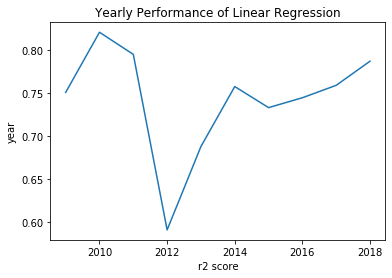

In [11]:
perf_model_year(lr, "Linear Regression", df)

/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.23678e-17): result may not be accurate.
  overwrite_a=True).T
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.3308e-17): result may not be accurate.
  overwrite_a=True).T
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.99571e-17): result may not be accurate.
  overwrite_a=True).T
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39125e-17): result may not be accurate.
  overwrite_a=True).T
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.03629e-17): result may not be acc

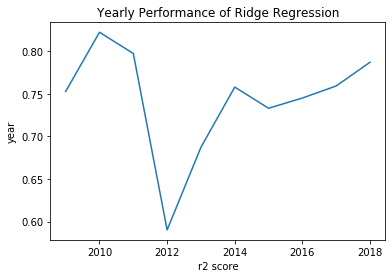

In [12]:
perf_model_year(rr, "Ridge Regression", df)

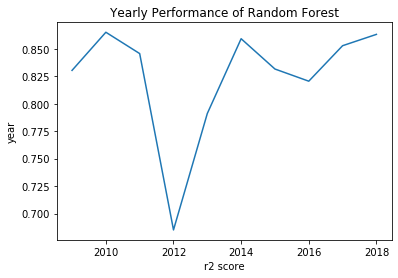

In [13]:
perf_model_year(rf, "Random Forest", df)

# Feature Elimination 
1. Correlated Features
2. PCA
3. RFE 
4. RFECV

In [31]:
# FROM: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = x.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [32]:
x_cr = x.drop(x[to_drop], axis=1)
print("r2_score: {:.3f}".format(get_score(lr, x_cr, y)))
print("r2_score: {:.3f}".format(get_score(rf, x_cr, y)))

r2_score: 0.781
r2_score: 0.861


## PCA

In [19]:
pca.fit(x_cr)
pca.components_ 

array([[-4.65977779e-10,  1.22150383e-08,  4.63466016e-06, ...,
        -1.02546550e-09, -2.64654519e-09, -7.96037183e-10],
       [ 1.68511554e-09, -9.69428915e-09,  9.13108866e-06, ...,
        -7.02439596e-09,  6.50097405e-09, -2.13816297e-09],
       [ 8.29036247e-06, -2.13267304e-06, -1.22880372e-02, ...,
         2.94044075e-06, -2.14715140e-06,  8.60238597e-07],
       ...,
       [-0.00000000e+00, -9.36757037e-14, -1.32420338e-17, ...,
        -3.10081821e-17, -1.73472348e-17, -7.32920669e-17],
       [-0.00000000e+00,  9.12886608e-15,  4.42970164e-18, ...,
         8.71698547e-17,  2.35922393e-16,  4.98299318e-16],
       [-0.00000000e+00, -6.95436022e-11, -7.76730702e-17, ...,
        -2.89260152e-13, -1.21603595e-12, -1.26833960e-12]])

In [20]:
pca.n_features_

149

## Recursive Feature Elimination

In [43]:
rfe = RFE(lr, step=3, n_features_to_select=25)
rfe.fit(x_cr, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=25, step=3, verbose=0)

In [45]:
x_rfe = x_cr[x_cr.columns[rfe.support_]]
print(x_rfe.columns)

Index(['longitude', 'latitude', 'baths', 'zoning_5', 'zoning_10', 'zoning_12',
       'zoning_13', 'zoning_14', 'zoning_15', 'shopping_6', 'shopping_11',
       'shopping_14', 'transportation_9', 'transportation_13',
       'transportation_16', 'pornography/obscene mat', 'views_BAY',
       'views_GGTE', 'views_LAKE', 'views_MRNA', 'parking_DECK',
       'parking_GSPC', 'type_4STR', 'type_PUD', 'type_TWNH'],
      dtype='object')


## RFE Cross Validation

In [37]:
# classifications
rfecv = RFECV(lr, step=5, min_features_to_select = 25,
              scoring='r2')
rfecv.fit(x, y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 175


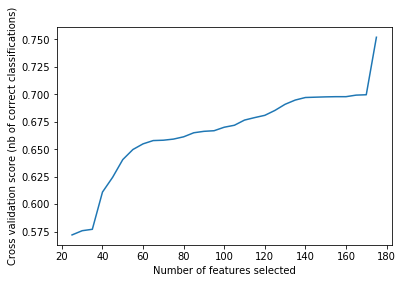

In [38]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(25, 5*len(rfecv.grid_scores_) + 25, 5), rfecv.grid_scores_)
plt.show()

# Linear Regression w/minimalized features

In [46]:
%%time
print("r2_score: {:.3f}".format(get_score(lr, x_rfe, y)))

r2_score: 0.593
CPU times: user 48.5 ms, sys: 14.4 ms, total: 62.9 ms
Wall time: 57.8 ms


# Re-Run Linear Regression w/Square Variables

In [47]:
%%time
print("r2_score: {:.3f}".format(get_score(rr_sq, x_rfe, y)))

r2_score: 0.682
CPU times: user 341 ms, sys: 69 ms, total: 410 ms
Wall time: 301 ms
